*Script criado por Natália Machado Crespo e Rafael Cesario de Abreu em Fev/2022 para o curso Aplicações em meteorologia usando Python*


#Aula 4
Nesta aula iremos:


*   Fazer composição de campos espaciais
*   Aplicar teste de significância estatística
*   Comparar diferentes conjuntos de dados (interpolar para a mesma grade e calcular alguns índices estatísticos)

In [ ]:
#Instalando pacotes e versões necessárias para o bom funcionamento do cartopy no Colab.
!pip uninstall -y shapely
!pip install -q netcdf4
!pip install shapely cartopy --no-binary shapely --no-binary cartopy

#Importando pacotes
import matplotlib.pyplot as plt #pacote para plot
import numpy as np #pacote para comandos gerais com os dados

import xarray as xr #pacote para abrir e trabalhar com o netcdf

import cartopy.crs as ccrs #pacote para mapas
import cartopy.feature as cfeat
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [ ]:
#Montando o drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Composições

Vamos selecionar meses característicos de El Niño e analisar como é a distribuição da precipitação no mundo.

Primeiro, vamos abrir o conjunto de dados de precipitação do NCEP que está no drive.

In [ ]:
pr = xr.open_dataset('/content/drive/Shareddrives/Curso_Python2022/dados_NCEP_NOAA/precip.mon.mean.nc')

In [ ]:
#Vamos ver como estão estes dados
pr

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, nv: 2, time: 516)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] ...
    lat_bnds   (lat, nv) float32 ...
    lon_bnds   (lon, nv) float32 ...
    precip     (time, lat, lon) float32 ...
Attributes: (12/18)
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    ...                    ...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2021/11 through latest.

Como vimos na aula anterior, os dados que estamos utilizando estão de 0-360°. 

Para otimizarmos o restante da nossa aula, vamos criar uma função que transforma as longitudes para o formato -180 a +180° antes de fazer qualquer operação.

In [ ]:
#Função que transforma a longitude dos dados
def transf_lon(ds):
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds['lon'])
    return ds

Agora, vamos aplicar a função criada no conjunto de interesse

In [ ]:
#Aplicando a função nos conjuntos de dados
pr = transf_lon(pr)

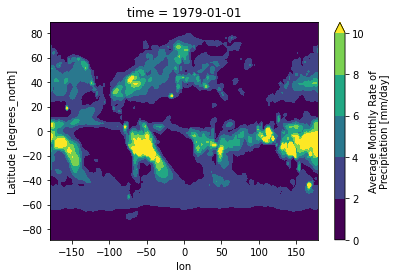

In [ ]:
#Plot rápido do mapa
pr.precip[0,:,:].plot.contourf(robust=True)

Para selecionarmos os meses característicos de El Niño (apenas a parte oceânica), iremos utilizar os valores mensais do índice disponibilizados no *website* da NOAA.

Lembrem-se que valores positivos (negativos) do índice Niño 3.4 indicam situação de aquecimento (resfriamento) na região do Pacífico Equatorial.

Geralmente, considera-se situação de El Niño (La Niña) quando os valores do Ocean Niño Index (ONI) permanecem positivo (negativos) por um período consecutivo de 3 meses, acima (abaixo) do limiar de +0,5°C (-0,5°C) na região do Niño 3.4 (5°N-5°S, 120°-170°W). Os meses Neutros referem-se às anomalias entre os limires de Niño e Niña. 

Lembrando que iremos selecionar apenas **meses característicos** dessas condições e não eventos. 

In [ ]:
#Abrindo dados do índice Niño3.4 utilizando o pacote pandas
import pandas as pd
nino_idx = pd.read_csv('/content/drive/Shareddrives/Curso_Python2022/nino34_timeseries.csv')

In [ ]:
nino_idx

,date,nino34
0,1870-01-01,-1.00
1,1870-02-01,-1.20
2,1870-03-01,-0.83
3,1870-04-01,-0.81
4,1870-05-01,-1.27
...,...,...
1819,2021-08-01,-0.38
1820,2021-09-01,-0.50
1821,2021-10-01,-0.78
1822,2021-11-01,NaN


Vemos que a primeira coluna contém as datas e a segunda os valores do índice. Vamos abrir nosso arquivo já passando as datas como índices para o dataframe, assim fica mais fácil de aplicar funções sobre os dados.

In [ ]:
nino_idx = pd.read_csv('/content/drive/Shareddrives/Curso_Python2022/nino34_timeseries.csv', parse_dates=True,index_col=0)

In [ ]:
nino_idx #Vejam que agora a coluna 'date' virou índice

,nino34
date,
1870-01-01,-1.00
1870-02-01,-1.20
1870-03-01,-0.83
1870-04-01,-0.81
1870-05-01,-1.27
...,...
2021-08-01,-0.38
2021-09-01,-0.50
2021-10-01,-0.78


Agora vamos selecionar as datas para a condição de anomalia da temperatura da superfície do mar para Niño. 

Vamos pegar somente as datas a partir de 1979 (para podermos relacionar com os dados de precipitação), ou seja, o índice do nosso dataframe.

In [ ]:
nino = nino_idx['1979':][nino_idx['nino34'] > 0.5].index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [ ]:
nino #128 meses com nino

DatetimeIndex(['1979-12-01', '1980-01-01', '1982-05-01', '1982-06-01',
               '1982-07-01', '1982-08-01', '1982-09-01', '1982-10-01',
               '1982-11-01', '1982-12-01',
               ...
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01'],
              dtype='datetime64[ns]', name='date', length=128, freq=None)

**Dica**: caso vocês esteja interessado em visualizar todas as linhas do dataframe, utilize o comando do pandas `pd.set_option('display.max_rows', None)`



Verificando o tipo da nossa variável nino

In [ ]:
type(nino)

pandas.core.indexes.datetimes.DatetimeIndex

Vamos agora selecionar as datas que queremos dentro dos dados de chuva. 

Aplicando o comando e selecionando apenas as datas do dataframe, ficamos com um *array* de índices do tipo DatetimeIndex. Por conta da interação entre o `xarray` e `pandas`, onde ambos usam objetos iguais para as datas, conseguimos extrair diretamente as datas do netCDF de precipitação.

In [ ]:
pr_nino = pr.sel(time=nino) 

In [ ]:
pr_nino

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, nv: 2, time: 128)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * time       (time) datetime64[ns] 1979-12-01 1980-01-01 ... 2020-01-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] 1979-12-01 1980-01-01 ... 2020-02-01
    lat_bnds   (lat, nv) float32 -90.0 -87.5 -87.5 -85.0 ... 85.0 87.5 87.5 90.0
    lon_bnds   (lon, nv) float32 180.0 182.5 182.5 185.0 ... 177.5 177.5 180.0
    precip     (time, lat, lon) float32 ...
Attributes: (12/18)
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    ...                    ...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2021/11 through latest.

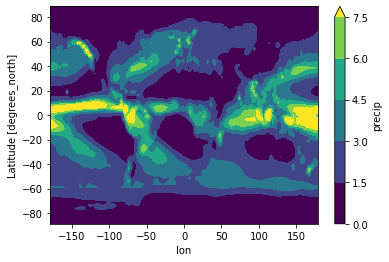

In [ ]:
#Visualizando o campo médio da precipitação média mensal em anos característicos de Niño
pr_nino['precip'].mean(dim='time').plot.contourf(robust=True) 

Comumente, analisamos este campo em termos de anomalia em relação à média climatológica; vamos visualizar, então, esse desvio para o mesmo período (a partir de 1979).

In [ ]:
#Selecionando os timesteps da nossa climatologia
pr_climat = pr.sel(time=slice('1991-01-01','2020-12-31'))

In [ ]:
pr_climat

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, nv: 2, time: 360)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * time       (time) datetime64[ns] 1991-01-01 1991-02-01 ... 2020-12-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] 1991-01-01 1991-02-01 ... 2021-01-01
    lat_bnds   (lat, nv) float32 -90.0 -87.5 -87.5 -85.0 ... 85.0 87.5 87.5 90.0
    lon_bnds   (lon, nv) float32 180.0 182.5 182.5 185.0 ... 177.5 177.5 180.0
    precip     (time, lat, lon) float32 ...
Attributes: (12/18)
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    ...                    ...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2021/11 through latest.

In [ ]:
#Subtraindo o campo médio de Niño pelo campo médio da climatologia
diff_nino = pr_nino.mean(dim='time') - pr_climat.mean(dim='time')

In [ ]:
diff_nino

<xarray.Dataset>
Dimensions:   (lat: 72, lon: 144, nv: 2)
Coordinates:
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon       (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
Dimensions without coordinates: nv
Data variables:
    lat_bnds  (lat, nv) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    lon_bnds  (lon, nv) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    precip    (lat, lon) float32 0.02358 0.01015 0.02065 ... -0.02939 -0.03695

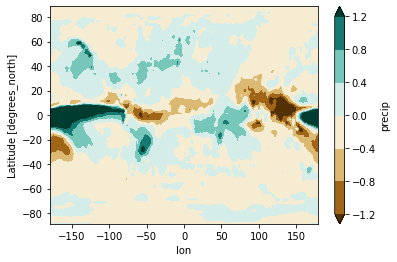

In [ ]:
#Visualizando as diferenças
diff_nino['precip'].plot.contourf(robust=True, cmap='BrBG')

#Aplicando teste de significância

Para sabermos o quão significativas são essas diferenças em relação à média climatológica ou mesmo entre séries (Niño x Niña, por exemplo), vamos aplicar um teste de significância estatística t-Student (ou somente teste t).

A equação a ser utilizada é: $t = \frac{\hat{x}_{1} - \hat{x}_{2}}{\sqrt{\frac{S^2_{x1}}{k}+\frac{S^2_{x2}}{l}}}$

Para isso, iremos utilizar o pacote `stats` do `scipy` já visto anteriormente.

In [ ]:
#Importando o pacote
from scipy import stats

mean1 = pr_nino.mean(dim="time") #fazendo a média no tempo para todos os pontos de grade do conjunto 1
std1 = pr_nino.std(dim="time") #desvio padrão de 1
nobs1 = len(pr_nino['time'].values) #extraindo o número de observações da série 1
mean2 = pr_climat.mean(dim="time") #fazendo a média no tempo para todos os pontos de grade do conjunto 2
std2 = pr_climat.std(dim="time") #desvio padrão de 2
nobs2 = len(pr_climat['time'].values) #extraindo o número de observações da série 2

In [ ]:
#Vamos aplicar o teste ponto a ponto fazendo um for
nx = pr_nino.dims['lon']
ny = pr_nino.dims['lat']

ttest_p = np.zeros((ny, nx))
ttest_s = np.zeros((ny, nx))
for i in np.arange(ny):
  for j in np.arange(nx):
     ttest_s[i,j], ttest_p[i,j] = stats.ttest_ind_from_stats(mean1['precip'][i,j], std1['precip'][i,j], nobs1,
                                                    mean2['precip'][i,j], std2['precip'][i,j], nobs2, equal_var=False)

In [ ]:
ttest_p.shape

(72, 144)

In [ ]:
ttest_p[0,0]

0.7267428226692565

Agora, para podermos plotar juntamente com a anomalia que calculamos, precisamos transformar os resultados do teste t para um DataArray, como fizemos na aula passada

In [ ]:
ttest_s = xr.DataArray(data= ttest_s, dims=['lat','lon'],
                            coords={'lat': pr_nino['lat'], 'lon': pr_nino['lon']})
ttest_p = xr.DataArray(data= ttest_p, dims=['lat','lon'],
                            coords={'lat': pr_nino['lat'], 'lon': pr_nino['lon']})

In [ ]:
ttest_s

<xarray.DataArray (lat: 72, lon: 144)>
array([[ 0.34992715,  0.17064238,  0.32870574, ..., -0.05303438,
         0.16399273,  0.19546008],
       [-2.17897251, -2.86010482, -3.01870969, ..., -2.96106219,
        -2.55547651, -2.91811814],
       [-2.27135023, -2.41602375, -2.45009208, ..., -3.24048307,
        -2.96578669, -2.7782267 ],
       ...,
       [-0.80399308, -0.71048676, -0.62120359, ..., -0.94702552,
        -0.93466421, -0.82459743],
       [-0.89576444, -0.8642615 , -0.80723669, ..., -1.32351649,
        -0.91360993, -0.92146064],
       [-1.02389491, -1.21837006, -0.94739871, ..., -0.90137363,
        -0.78763772, -0.89843233]])
Coordinates:
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8

Assim, temos dois DataArrays contendo a estatística t e o p valor. Agora, vamos fazer o plot.

Text(0.5, 1.0, 'nino - climat')

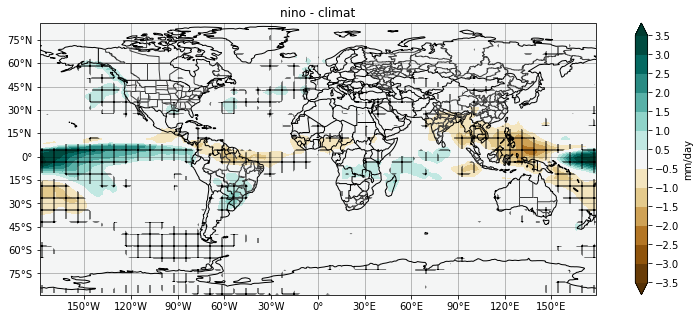

In [ ]:
#Ajustando o tamanho da figura; projeção cartográfica
fig, ax = plt.subplots(figsize=(14,5), subplot_kw={'projection': ccrs.PlateCarree()})

#Criando um array de valores que serão utilizados para os eixos de latitude e longitude do mapa
xticks = np.arange(-180,210,30)
yticks = np.arange(-90,105,15)

#Funções do cartopy
ax.coastlines()
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

#Países
ax.add_feature(cfeat.BORDERS)

#Estados
states_provinces = cfeat.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='0.25')

#Linhas de grade
ax.grid(c='k', ls='-', alpha=0.3)

#Array de valores para a barra de cores
colorb=[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0.5,1,1.5,2,2.5,3,3.5]

#Comando para fazer o plot da anomalia de precipitação
cf = ax.contourf(diff_nino.lon,diff_nino.lat, diff_nino['precip'], levels=colorb, extend='both', cmap='BrBG')

#Comando para fazer o plot do teste estatístico
#Utilizando o limiar p <= 0.05, plotaremos apenas valores ao nível de significância de 5%
ax.contourf(ttest_p['lon'], ttest_p['lat'], ttest_p <= 0.05, colors='none', hatches='+', levels=[.5,1.5])

#Barra de cores
cbar=plt.colorbar(cf,ticks=colorb, label='mm/day')

#Título
ax.set_title('nino - climat')

Um forma alternativa de aplicarmos o teste (ou qualquer outra função em cima dos nossos dados) é utilizando a função do `xarray` `apply_ufunc`.

Iremos criar uma função onde o teste será aplicado para todos os pontos de grade utilizando o `apply_ufunc`.

In [ ]:
#Definindo uma função onde será aplicado o teste para todo o globo entre dois conjuntos de dados: ds1 e ds2
def composite_significante(ds1, ds2, equal_var=False):
    """
    Calculate composite significance using t test
    """
    mean1 = ds1.mean("time") #fazendo a média no tempo para todos os pontos de grade do conjunto ds1
    std1 = ds1.std("time") #desvio padrão de ds1
    nobs1 = len(ds1['time'].values) #extraindo o número de observações da série ds1
    mean2 = ds2.mean("time") #fazendo a média no tempo para todos os pontos de grade do conjunto ds2
    std2 = ds2.std("time") #desvio padrão de ds2
    nobs2 = len(ds2['time'].values) #extraindo o número de observações da série ds2

 #Aplicando a função do teste estatístico utilizando o comando ufunc. 
 #Nesse caso, a função do teste será mapeada sobre todas as variáveis e coordenadas dos arquivos.
    return xr.apply_ufunc(
        stats.ttest_ind_from_stats,
        mean1,
        std1,
        nobs1,
        mean2,
        std2,
        nobs2,
        equal_var,
        input_core_dims=[[], [], [], [], [], [], []],
        output_core_dims=[[], []],
        vectorize=True,
        dask="parallelized",
    )

Agora vamos aplicar o teste de significância entre os diferentes conjuntos e plotar.

In [ ]:
#Niño x Climatologia
#Passando o comando equal_var=False, estamos dizendo que a variância das populações são diferentes.
#Como retorno da função aplicada, teremos os valores do teste de significância e o p-value
ds_t_nino_climat, ds_p_nino_climat = composite_significante(pr_nino['precip'],pr_climat['precip'], equal_var=False)

In [ ]:
ds_t_nino_climat #vejam que para cada lat,lon temos um valor do teste estatístico

<xarray.DataArray 'precip' (lat: 72, lon: 144)>
array([[ 0.34992715,  0.17064238,  0.32870574, ..., -0.05303438,
         0.16399273,  0.19546008],
       [-2.17897246, -2.86010479, -3.01870964, ..., -2.96106214,
        -2.55547649, -2.91811813],
       [-2.27135018, -2.41602376, -2.45009207, ..., -3.24048303,
        -2.96578666, -2.77822672],
       ...,
       [-0.80399308, -0.71048676, -0.62120359, ..., -0.94702554,
        -0.9346642 , -0.82459743],
       [-0.89576444, -0.8642615 , -0.80723669, ..., -1.32351649,
        -0.91360994, -0.92146063],
       [-1.02389491, -1.21837007, -0.94739869, ..., -0.90137364,
        -0.78763771, -0.89843233]])
Coordinates:
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8

In [ ]:
ds_p_nino_climat #e também do p-value

<xarray.DataArray 'precip' (lat: 72, lon: 144)>
array([[0.72674282, 0.86466675, 0.74271861, ..., 0.95775726, 0.8698933 ,
        0.84522984],
       [0.03029141, 0.00459256, 0.00280477, ..., 0.00335968, 0.01120678,
        0.00382941],
       [0.0238912 , 0.01635675, 0.01490036, ..., 0.00133342, 0.00327613,
        0.00583327],
       ...,
       [0.42209048, 0.47800162, 0.53499785, ..., 0.34441865, 0.35075703,
        0.41028751],
       [0.37118968, 0.38822601, 0.42026659, ..., 0.18676036, 0.36172612,
        0.35765607],
       [0.30686168, 0.22416969, 0.34436111, ..., 0.36827938, 0.43160659,
        0.36985737]])
Coordinates:
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8

Agora, vamos fazer o *plot* da anomalia de precipitação juntamente com o teste de significância estatística.

Text(0.5, 1.0, 'nino - climat')

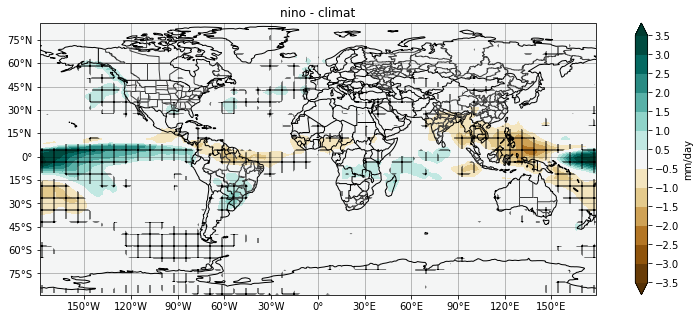

In [ ]:
#Ajustando o tamanho da figura; projeção cartográfica
fig, ax = plt.subplots(figsize=(14,5), subplot_kw={'projection': ccrs.PlateCarree()})

#Criando um array de valores que serão utilizados para os eixos de latitude e longitude do mapa
xticks = np.arange(-180,210,30)
yticks = np.arange(-90,105,15)

#Funções do cartopy
ax.coastlines()
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

#Países
ax.add_feature(cfeat.BORDERS)

#Estados
states_provinces = cfeat.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='0.25')

#Linhas de grade
ax.grid(c='k', ls='-', alpha=0.3)

#Array de valores para a barra de cores
colorb=[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0.5,1,1.5,2,2.5,3,3.5]

#Comando para fazer o plot da anomalia de precipitação
cf = ax.contourf(diff_nino.lon,diff_nino.lat, diff_nino['precip'], levels=colorb, extend='both', cmap='BrBG')

#Comando para fazer o plot do teste estatístico
#Utilizando o limiar p <= 0.05, plotaremos apenas valores ao nível de significância de 5%
ax.contourf(ds_p_nino_climat['lon'], ds_p_nino_climat['lat'], ds_p_nino_climat <= 0.05, colors='none', hatches='+', levels=[.5,1.5])

#Barra de cores
cbar=plt.colorbar(cf,ticks=colorb, label='mm/day')

#Título
ax.set_title('nino - climat')

#Comparação entre conjuntos de dados

Vamos abrir o conjunto de dados de precipitação do modelo ACCESS1-0 para comparar com a reanálise do NCEP (pr)

In [ ]:
#Abrindo o arquivo netcdf que está no drive
ds1 = xr.open_dataset('/content/drive/Shareddrives/Curso_Python2022/dados_cmip5/pr_Amon_ACCESS1-0_historical_r1i1p1_185001-200512.nc')

In [ ]:
#Vamos ver como estão estes dados
ds1

<xarray.Dataset>
Dimensions:  (lat: 145, lon: 192, time: 1872)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2005-12-01
Data variables:
    pr       (time, lat, lon) float32 ...
Attributes: (12/28)
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          historical
    source:                 ACCESS1-0 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1-0
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    ...                     ...
    table_id:               Table Amon (27 April 2011) 9c851218e3842df9a62ef3...
    title:                  ACCESS1-0 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.0

Latitude a cada 1.25°

Longitude a cada 1.875°

In [ ]:
pr

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, nv: 2, time: 516)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-01-01
    lat_bnds   (lat, nv) float32 -90.0 -87.5 -87.5 -85.0 ... 85.0 87.5 87.5 90.0
    lon_bnds   (lon, nv) float32 180.0 182.5 182.5 185.0 ... 177.5 177.5 180.0
    precip     (time, lat, lon) float32 ...
Attributes: (12/18)
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    ...                    ...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2021/11 through latest.

Latitude e longitude a cada 2.5°

Vamos dar uma olhada rápida no mapa espacial

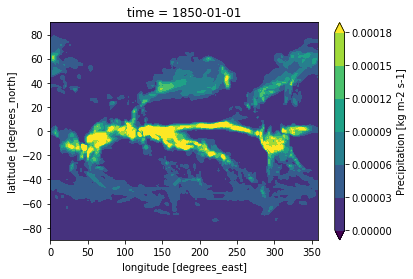

In [ ]:
ds1['pr'][0,:,:].plot.contourf(robust=True)

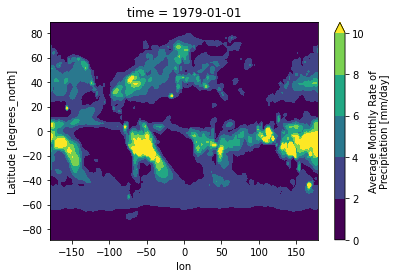

In [ ]:
pr['precip'][0,:,:].plot.contourf(robust=True)

Vejam que os valores de precipitação também são diferentes.

Queremos fazer uma breve comparação entre cada conjunto de dados. Para isso, primeiramente teremos que:

1) padronizar as unidades de precipitação 

2) selecionar o mesmo "período" 

3) interpolar os dados do ACCESS1-0 para a mesma grade do NCEP.

In [ ]:
#Modificando a unidade de precipitação do conjunto Nor
#De kg m-2 s-1 (fluxo) para mm dia-1 (taxa)
ds1['pr'] = ds1['pr'][:,:,:]*86400
ds1

<xarray.Dataset>
Dimensions:  (lat: 145, lon: 192, time: 1872)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2005-12-01
Data variables:
    pr       (time, lat, lon) float64 0.09897 0.09897 0.09897 ... 0.7284 0.7284
Attributes: (12/28)
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          historical
    source:                 ACCESS1-0 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1-0
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    ...                     ...
    table_id:               Table Amon (27 April 2011) 9c851218e3842df9a62ef3...
    title:                  ACCESS1-0 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.0

In [ ]:
pr['precip'][0,:,:]
#Agora os valores estão comparáveis

<xarray.DataArray 'precip' (lat: 72, lon: 144)>
array([[0.0436  , 0.023647, 0.072827, ..., 0.      , 0.003934, 0.004964],
       [0.235769, 0.298262, 0.294526, ..., 0.094532, 0.217604, 0.177189],
       [0.251554, 0.181796, 0.157738, ..., 0.065101, 0.152101, 0.155427],
       ...,
       [0.410603, 0.356705, 0.310445, ..., 0.479744, 0.486918, 0.449291],
       [0.397805, 0.384389, 0.389664, ..., 0.524346, 0.50328 , 0.452041],
       [0.471718, 0.460059, 0.371636, ..., 0.583462, 0.619336, 0.50102 ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
    time     datetime64[ns] 1979-01-01
Attributes:
    long_name:     Average Monthly Rate of Precipitation
    valid_range:   [  0. 100.]
    units:         mm/day
    precision:     32767
    var_desc:      Precipitation
    dataset:       GPCP Version 2.3 Combined Precipitation Dataset
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Mean
    actual_range:  [ 0.       47.327435]

Selecionando o mesmo período para ambos os conjuntos (1979 a 2005)

In [ ]:
ds1 = ds1.sel(time=slice('1979-01-01', '2005-12-01'))

#Vamos chamar o arquivo de precipitação da NOAA de ds2 para indicar que é o período de 1979-2005
ds2 = pr.sel(time=slice('1979-01-01', '2005-12-01'))

In [ ]:
ds1

<xarray.Dataset>
Dimensions:  (lat: 145, lon: 192, time: 324)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2005-12-01
Data variables:
    pr       (time, lat, lon) float64 0.2673 0.2673 0.2673 ... 0.7284 0.7284
Attributes: (12/28)
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          historical
    source:                 ACCESS1-0 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1-0
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    ...                     ...
    table_id:               Table Amon (27 April 2011) 9c851218e3842df9a62ef3...
    title:                  ACCESS1-0 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.0

In [ ]:
ds2

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, nv: 2, time: 324)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2005-12-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] ...
    lat_bnds   (lat, nv) float32 ...
    lon_bnds   (lon, nv) float32 ...
    precip     (time, lat, lon) float32 ...
Attributes: (12/18)
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    ...                    ...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2021/11 through latest.

Agora vamos interpolar as lat e lons do ACCESS para o formato do NCEP.




In [ ]:
#Primeiramente, vamos transformar a longitude dos dados do Nor para -180 a +180°
ds1 = transf_lon(ds1)

In [ ]:
ds1

<xarray.Dataset>
Dimensions:  (lat: 145, lon: 192, time: 324)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 -180.0 -178.1 -176.2 -174.4 ... 174.4 176.2 178.1
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2005-12-01
Data variables:
    pr       (time, lat, lon) float64 0.2673 0.2673 0.2673 ... 0.7284 0.7284
Attributes: (12/28)
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          historical
    source:                 ACCESS1-0 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1-0
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    ...                     ...
    table_id:               Table Amon (27 April 2011) 9c851218e3842df9a62ef3...
    title:                  ACCESS1-0 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.0

In [ ]:
#Interpolando os dados do Nor para a mesma grade lat e lon do NCEP
ds1_interp = ds1.interp(lat=ds2.lat, lon=ds2.lon)

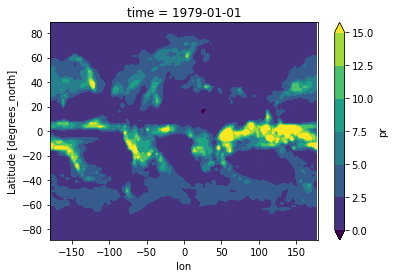

In [ ]:
ds1_interp['pr'][0,:,:].plot.contourf(robust=True) #dados interpolados

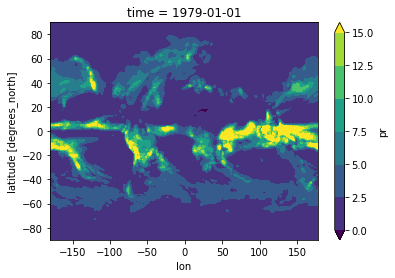

In [ ]:
ds1['pr'][0,:,:].plot.contourf(robust=True) #dados não interpolados

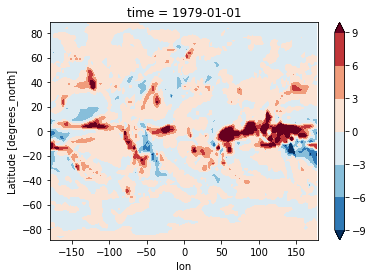

In [ ]:
#Diferença entre a precipitação do ACCESS e NCEP para janeiro de 1979
(ds1_interp['pr'][0,:,:]-ds2['precip'][0,:,:]).plot.contourf(robust=True)

Vamos calcular algumas estatísticas entre os conjuntos, como média, desvio padrão, correlação, RMSE para os dados globais

In [ ]:
#Vamos fazer com a série temporal global de ambos os conjuntos, ou seja, aplicamos a média nas dimensões lat e lon
ts_access = ds1_interp['pr'].mean(dim=['lat','lon'])
ts_ncep = ds2['precip'].mean(dim=['lat', 'lon'])

In [ ]:
ts_access

<xarray.DataArray 'pr' (time: 324)>
array([2.40032037, 2.49876803, 2.44788589, 2.51367387, 2.50756633,
       2.57009749, 2.62810504, 2.54700509, 2.5160863 , 2.49314716,
       2.47446071, 2.41122313, 2.42247033, 2.42868237, 2.47494623,
       2.46980485, 2.48738951, 2.63089164, 2.59007794, 2.56988296,
       2.50875025, 2.46343744, 2.45974138, 2.46382855, 2.41767023,
       2.44859708, 2.47860417, 2.53407574, 2.56574116, 2.59751723,
       2.64139815, 2.53139645, 2.5146816 , 2.46150427, 2.47379779,
       2.43709145, 2.39863149, 2.46714126, 2.44377682, 2.51912987,
       2.52983719, 2.5947478 , 2.58978722, 2.58281483, 2.50615983,
       2.48980692, 2.45078358, 2.40495664, 2.43309304, 2.41259451,
       2.44761446, 2.45351656, 2.50609142, 2.58087654, 2.60176534,
       2.52683324, 2.48112035, 2.47503874, 2.45532624, 2.43764284,
       2.391341  , 2.42843344, 2.48037795, 2.49417737, 2.55082925,
       2.60622291, 2.58137083, 2.54488174, 2.49486187, 2.45030016,
       2.38715992, 2.45600227, 2.37977771, 2.44448727, 2.50790683,
       2.50741261, 2.52771063, 2.56626974, 2.61420841, 2.53099411,
       2.49321435, 2.44340654, 2.40874026, 2.42348218, 2.41280492,
       2.4613368 , 2.43030979, 2.50598778, 2.52411612, 2.60746563,
       2.58327089, 2.54816914, 2.51723518, 2.47491405, 2.44135984,
       2.45593663, 2.4240099 , 2.4546753 , 2.46533651, 2.4967641 ,
...
       2.5302558 , 2.46895284, 2.4640674 , 2.44809812, 2.46715185,
       2.50551076, 2.509021  , 2.57972143, 2.61266294, 2.6081466 ,
       2.5857578 , 2.50345627, 2.53619307, 2.48009974, 2.43668325,
       2.40902223, 2.51843984, 2.52393605, 2.52039661, 2.57191988,
       2.61874306, 2.60473328, 2.57865811, 2.51630842, 2.52639716,
       2.48119869, 2.44920668, 2.46382408, 2.43819303, 2.54040253,
       2.54491035, 2.58953832, 2.6646521 , 2.63137235, 2.60781512,
       2.5315552 , 2.43766297, 2.51326795, 2.46785158, 2.42644758,
       2.44442464, 2.42664788, 2.51725255, 2.53256272, 2.61114785,
       2.64113357, 2.597412  , 2.51778565, 2.49304204, 2.45724988,
       2.45960068, 2.45920654, 2.457742  , 2.48716109, 2.50822552,
       2.54560243, 2.59230466, 2.59892879, 2.56411867, 2.59180436,
       2.51135235, 2.49421377, 2.46043727, 2.4815219 , 2.40405139,
       2.45717827, 2.49910747, 2.58596905, 2.62049285, 2.63374182,
       2.57391765, 2.51878734, 2.4975564 , 2.5069316 , 2.46727295,
       2.47224375, 2.50275277, 2.48139088, 2.52207137, 2.55564049,
       2.64721806, 2.63581455, 2.58013667, 2.51469356, 2.54393397,
       2.47231175, 2.41519915, 2.46053008, 2.46799246, 2.52360493,
       2.52929619, 2.52991535, 2.63074691, 2.62209925, 2.60453893,
       2.57089292, 2.49030367, 2.44401242, 2.49945766])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2005-12-01

In [ ]:
ts_ncep

<xarray.DataArray 'precip' (time: 324)>
array([2.2292771, 2.2804475, 2.2299366, 2.168095 , 2.1511614, 2.2654889,
       2.2880352, 2.3198175, 2.3091395, 2.192283 , 2.2611628, 2.1189845,
       2.1930618, 2.1715076, 2.1943588, 2.1213706, 2.1173515, 2.211017 ,
       2.2187119, 2.3135662, 2.2677977, 2.23713  , 2.2006016, 2.1531363,
       2.2530138, 2.2091374, 2.1678128, 2.1725585, 2.1166623, 2.2348535,
       2.2849889, 2.3117392, 2.3049824, 2.2452931, 2.2775834, 2.1975803,
       2.240943 , 2.1855884, 2.3222623, 2.2372303, 2.1891243, 2.277669 ,
       2.2732513, 2.3993134, 2.3183498, 2.230344 , 2.2437847, 2.2401507,
       2.2358222, 2.2110827, 2.1936004, 2.1489692, 2.1449518, 2.283014 ,
       2.3510232, 2.3603377, 2.2971792, 2.3079643, 2.267511 , 2.1975193,
       2.2325895, 2.2375765, 2.1863494, 2.16849  , 2.1534922, 2.291324 ,
       2.3024151, 2.339953 , 2.2741957, 2.3162134, 2.2401414, 2.1727982,
       2.1537123, 2.275534 , 2.2270424, 2.1475148, 2.16461  , 2.2156522,
       2.2706966, 2.382865 , 2.2838023, 2.3589356, 2.2871745, 2.1777508,
       2.2291315, 2.0930996, 2.243158 , 2.1852157, 2.145066 , 2.250442 ,
       2.2811272, 2.320084 , 2.2863038, 2.1477027, 2.2322927, 2.2020016,
       2.2233975, 2.215939 , 2.2083476, 2.1457434, 2.1347656, 2.2019799,
       2.2933655, 2.3049285, 2.275952 , 2.2724066, 2.247026 , 2.1467502,
       2.088058 , 2.199651 , 2.2975245, 2.1661444, 2.1853073, 2.242424 ,
       2.381731 , 2.3957758, 2.3239756, 2.2229676, 2.2077312, 2.1813493,
...
       2.2979128, 2.3123467, 2.2968698, 2.233815 , 2.2716093, 2.0572486,
       2.2352784, 2.1959233, 2.2244847, 2.2078154, 2.215564 , 2.2013454,
       2.2975936, 2.3812237, 2.307292 , 2.2415218, 2.2111585, 2.208795 ,
       2.2123768, 2.2266035, 2.2924995, 2.2088628, 2.2154117, 2.2963197,
       2.3188794, 2.4075286, 2.3438563, 2.301659 , 2.2000546, 2.230522 ,
       2.1841712, 2.221435 , 2.1067986, 2.1333766, 2.1909509, 2.2074885,
       2.3178964, 2.3079925, 2.327134 , 2.2904263, 2.2976975, 2.1676092,
       2.1785097, 2.1484013, 2.1780968, 2.1218634, 2.175032 , 2.2357967,
       2.3183348, 2.2877972, 2.2950218, 2.2193267, 2.168684 , 2.132875 ,
       2.1019137, 2.1097438, 2.146023 , 2.137602 , 2.182375 , 2.2538145,
       2.3130684, 2.2855926, 2.2340968, 2.247229 , 2.2613816, 2.1588492,
       2.2662055, 2.2275739, 2.2623382, 2.1264203, 2.1833413, 2.2859156,
       2.2588732, 2.2913644, 2.2703059, 2.1803453, 2.1846962, 2.1811564,
       2.2824306, 2.248656 , 2.276601 , 2.1855555, 2.2159038, 2.207733 ,
       2.2709172, 2.3695495, 2.341767 , 2.246045 , 2.207161 , 2.2372253,
       2.218872 , 2.274565 , 2.3215096, 2.1748514, 2.172354 , 2.242828 ,
       2.1638026, 2.3062112, 2.283701 , 2.2376451, 2.2539356, 2.2673779,
       2.3264868, 2.297869 , 2.3325608, 2.245029 , 2.1811364, 2.2229571,
       2.3045197, 2.3610656, 2.3640602, 2.3079884, 2.1834059, 2.2134051],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2005-12-01

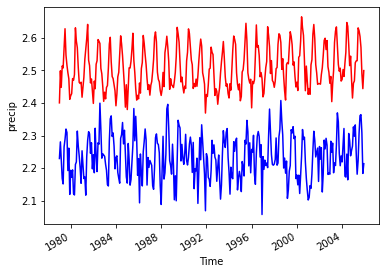

In [ ]:
#Série temporal global
ts_access.plot(color='red')
ts_ncep.plot(color='blue')

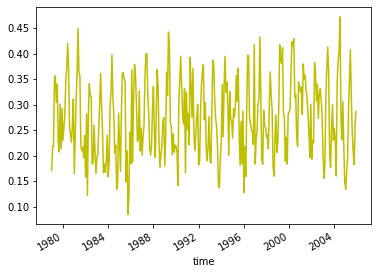

In [ ]:
#Diferenças
(ts_access-ts_ncep).plot(color='y')

In [ ]:
#Desvio padrão
print('std nor = ', ts_access.std(), 'std ncep = ', ts_ncep.std())

std nor =  <xarray.DataArray 'pr' ()>
array(0.0648022) std ncep =  <xarray.DataArray 'precip' ()>
array(0.06619355)


In [ ]:
#Correlação
corr = xr.corr(ts_access, ts_ncep)
corr

<xarray.DataArray ()>
array(0.34739968)

In [ ]:
#Utilizando o pacote scikit.learn para calcular os MSE e RMSE
from sklearn.metrics import mean_squared_error

In [ ]:
#MSE das séries médias globais
print(mean_squared_error(ts_ncep, ts_access))

0.08001850798124005


In [ ]:
#RMSE das séries médias globais
print(mean_squared_error(ts_ncep, ts_access, squared = False))

0.28287542838012647


In [ ]:
#BIAS das séries médias globais
def calculate_bias(y, x):
  return (y - x).mean()

In [ ]:
calculate_bias(ts_access,ts_ncep)

<xarray.DataArray ()>
array(0.2727965)

In [ ]:
#Correlação no tempo para cada ponto no espaço
corr_space = xr.corr(ds1_interp['pr'], ds2['precip'], dim='time')

In [ ]:
corr_space

<xarray.DataArray (lat: 72, lon: 144)>
array([[-0.22255194, -0.23066001, -0.24576103, ..., -0.25301784,
        -0.22096626,         nan],
       [-0.18605891, -0.13312558, -0.10950721, ..., -0.21578536,
        -0.21027822,         nan],
       [-0.06332512, -0.04637706, -0.00368753, ..., -0.02116946,
        -0.02630082,         nan],
       ...,
       [ 0.64552935,  0.63173402,  0.63731562, ...,  0.61837074,
         0.62586604,         nan],
       [ 0.5764958 ,  0.55403897,  0.56633506, ...,  0.58088522,
         0.5756103 ,         nan],
       [ 0.54036103,  0.46451605,  0.49495921, ...,  0.49042973,
         0.54540097,         nan]])
Coordinates:
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8

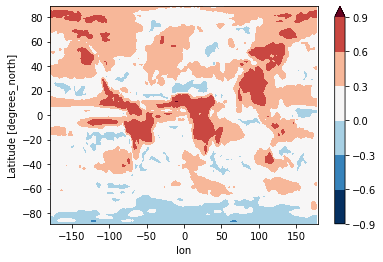

In [ ]:
corr_space.plot.contourf(robust=True)

**Exercício**: A partir dos dados de temperatura do ar (air), pressão reduzida ao nível médio do mar (mslp) e precipitação (precip) do NCEP e índice Niño3.4:

a) Utilize o `salem` para selecionar um país de sua preferência. Em seguida, aplique a máscara nos dados de precipitação

b) Selecione meses com condições de La Niña, El Niño e Neutro 

c) Calcule a significância estatística entre cada conjunto

d) Faça o *plot* espacial da diferença entre os conjuntos e a significância estatística